In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm

In [2]:
S0= 100             # Stock price today
K= 100              # Strike price
barrier = 150       # Barrier level
T= 1                # Maturity in years
n_simulation = 51   # number of simulations
sigmaj = 0.2
#Firm specific information
v0=200
debt=175
recovery_rate=0.25
correlation=0.2
t=np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
bond_price=np.array([100,99.38,98.76,98.15,97.54,96.94,96.34,95.74,95.16,94.57,93.99,93.42,92.85])
gamma=0.75

In [3]:
def compound_interest(Libor,dt):
    return np.log(1 + Libor * dt) / dt

In [4]:
# Applying the  LIBOR forward rate model algorithms and simulating interest rates.
np.random.seed(0)
n_simulations = 100000
n_steps = len(t)

mc_forward = np.ones([n_simulations,n_steps-1])*(bond_price[:-1]-bond_price[1:])/(2*bond_price[1:])
predcorr_forward = np.ones([n_simulations,n_steps-1])*(bond_price[:-1]-bond_price[1:])/(2*bond_price[1:])
predcorr_capfac = np.ones([n_simulations,n_steps])
mc_capfac = np.ones([n_simulations,n_steps])

delta = np.ones([n_simulations,n_steps-1])*(t[1:]-t[:-1])

corr_matrix = np.array([[1, correlation],[correlation, 1]])
norm_matrix = norm.rvs(size = np.array([2,n_simulations*n_steps]))
corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)

# Random Variables for Stock and Firm value simulations
norm_stock = np.reshape(corr_norm_matrix[0,], (n_simulations, n_steps)) 
norm_firm = np.reshape(corr_norm_matrix[1,], (n_simulations, n_steps)) 

# Interest rate initialisation
r = compound_interest(predcorr_forward[0,0], delta[0,0])
r_sim = np.zeros([n_simulations,n_steps - 1])
r_sim[:,0] = r 

# Arrays to store sigma values for firm and stock path. Initial value is 1 since we take a cumulative product
sigma_stock = np.ones([n_simulations,n_steps - 1])
sigma_firm = np.ones([n_simulations,n_steps - 1])

# Arrays to hold Stock path and Firm values
S = np.zeros([n_simulations,n_steps])
S[:,0] = S0

V = np.zeros([n_simulations,n_steps+1])
V[:,0] = v0 #Sets the first column to V_0 = 200


In [5]:
for i in range(1,n_steps):
    Z = norm.rvs(size = [n_simulations,1])
    
    # Explicit Monte Carlo simulation
    muhat = np.cumsum(delta[:,i:]*mc_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*mc_forward[:,i:]),axis = 1)
    mc_forward[:,i:] = mc_forward[:,i:]*np.exp((muhat-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    
    # Predictor-Corrector Montecarlo simulation
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*predcorr_forward[:,i:]),axis = 1)
    for_temp = predcorr_forward[:,i:]*np.exp((mu_initial-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    mu_term = np.cumsum(delta[:,i:]*for_temp*sigmaj**2/(1+delta[:,i:]*for_temp),axis = 1)
    predcorr_forward[:,i:] = predcorr_forward[:,i:]*np.exp((mu_initial+mu_term-sigmaj**2)*delta[:,i:]/2+sigmaj*np.sqrt(delta[:,i:])*Z)
    
    #Simulating LIBOR rates
    r_sim[:,i:n_steps] = compound_interest(predcorr_forward[:,i:n_steps], delta[:,i:n_steps]) 
    
    # Simulating stock path
    sigma_stock[:,i-1] = 0.3*(S[:,i-1])**(gamma-1)
    S[:,i] = S[:,i-1]*np.exp((r_sim[:,i-1]-sigma_stock[:,i-1]**2/2)*(delta[:,i-1])+ sigma_stock[:,i-1]*norm_stock[:,i-1]*np.sqrt(delta[:,i-1]))
    
    # Simulating firm values
    sigma_firm[:,i-1] = 0.3*(V[:,i-1])**(gamma-1)
    V[:,i] = V[:,i-1]*np.exp((r_sim[:,i-1]-sigma_firm[:,i-1]**2/2)*(delta[:,i-1])+ sigma_firm[:,i-1]*norm_firm[:,i-1]*np.sqrt(delta[:,i-1]))
    
# Implying capitalisation factors from the forward rates

mc_capfac[:,1:] = np.cumprod(1+delta*mc_forward, axis = 1)
predcorr_capfac[:,1:] = np.cumprod(1+delta*predcorr_forward, axis = 1)

# Inverting the capitalisation factors to imply bond prices (discount factors)
mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)

# Taking averages
mc_final = np.mean(mc_price,axis = 0)
predcorr_final = np.mean(predcorr_price,axis = 0)

KeyboardInterrupt: 

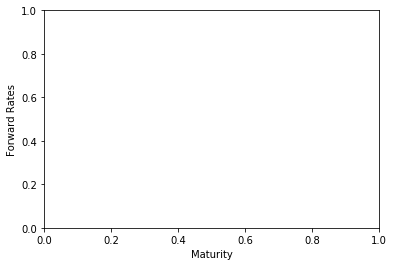

In [22]:
times = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel("Maturity")
plt.ylabel("Forward Rates")
plt.plot(times,mc_forward.transpose(),'o', label = "Simple Monte Carlo Bond Prices")
plt.plot(times,predcorr_forward.transpose(),'x', label = "Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

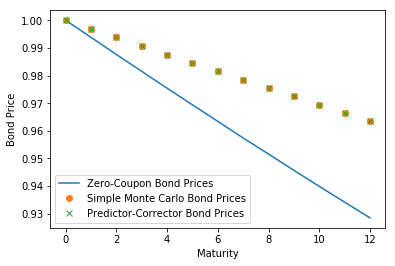

In [6]:
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(t,bond_price/100, label = "Zero-Coupon Bond Prices")
plt.plot(t,mc_final,'o', label = "Simple Monte Carlo Bond Prices")
plt.plot(t,predcorr_final,'x', label = "Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

In [16]:
# Plot Stock prices path
plt.plot(S.iloc[:0,1000])
plt.title("Stock Price Simulations")

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [8]:
# Plot Firm value path
plt.plot(V.iloc[:0,1000])
plt.title("Firm Price Simulation")

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
# Plot sigma for firm and stock values


In [17]:
def find_call_payoff(S,K,r):
    return np.exp(-r * T) * np.maximum(S - K,0)

In [18]:
def up_and_out_call_price(S,r):
    total = 0
    out = np.max(S,axis = 1) > barrier
    for j in range(0, n_simulations):
        if out[j] == False:
            total += call_payoff(S_sim[j, n_steps], r[j])
    return total/n_simulations


In [19]:
def calculate_CVA(V, r, payoff):
    amount_lost = 0
    for i in range(0, n_simulations):
        if V_sim[i, n_steps] < debt:
            amount_lost += np.exp(-r_T[i])*(1-recovery_rate)*payoff
    return amount_lost/n_simulations

In [20]:
rT = T * np.sum(r_sim,axis = 1) / 12
payoff = up_and_out_call_price(S,rT)
print("Price of up and out Call Option : {}".format(payoff))


NameError: name 'call_payoff' is not defined

In [21]:
cva_est = calculate_CVA(V,rT,payoff)
print("Price of up and out call option adjusted with CVA : {}".format(payoff-cva_est))

NameError: name 'payoff' is not defined